In [1]:
import time
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

In this notebook, SQLAlchemy is used to retrieve data from the database, unlike the CSV files usually encountered on Kaggle.<br>
<br>
**What is SQLAlchemy?**<br>
SQLAlchemy is a Python library that essentially allows you to work with databases from the comfort of your notebook. It supports multiple Database Management Systems (DBMS) like SQLite, PostgreSQL, MySQL, and Oracle.<br><br>
Some details may vary with different database flavors, but the general idea is similar to our most simplified case, namely SQLite. First, let's create an engine and establish connection with our database and see some really basic info like the list of tables within our database.

In [2]:
from sqlalchemy import create_engine, inspect

# Create a database engine
engine = create_engine('sqlite:///transactional_data.db')
# Context manager is used to establish a connection
with engine.connect() as conn:
    # SQLAlchemy's Inspector is used to retrieve table names
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
# Print the table names
print(table_names)

['order_items', 'order_reviews', 'orders', 'products', 'sellers']


Let's follow up on these tables and print out some essential details.

In [3]:
# Context manager is used to establish a connection
with engine.connect() as conn:
    inspector = inspect(engine)    
    for table_name in inspector.get_table_names():
        # Retrieve column information
        columns_info = inspector.get_columns(table_name)
        columns = [col['name'] for col in columns_info]        
        # Check for primary key
        primary_key = next((col['name'] for col in columns_info if col['primary_key']), None)        
        # Check for foreign keys
        foreign_keys_info = inspector.get_foreign_keys(table_name)
        foreign_key_columns = [fk['constrained_columns'][0] for fk in foreign_keys_info]        
        # Count the number of records in the table
        num_records_query = f"SELECT COUNT(*) FROM '{table_name}'"
        num_records = conn.execute(num_records_query).scalar()        
        # Print results
        print(f"\033[1m'{table_name}'\033[0m")
        print(f"Primary Key: {primary_key}")
        if foreign_key_columns:
            print("Foreign Key Column(s):")
            for fk_column in foreign_key_columns:
                print(f"  - {fk_column}")
        else:
            print("Foreign Key: None")
        print(f"Columns: {columns}")
        print(f"Number of Records: {num_records}\n")

'order_items'
Primary Key: order_items_pk
Foreign Key Column(s):
  - order_id
  - product_id
  - seller_id
Columns: ['order_items_pk', 'order_id', 'product_id', 'seller_id', 'price']
Number of Records: 110197

'order_reviews'
Primary Key: review_id
Foreign Key Column(s):
  - order_id
Columns: ['review_id', 'order_id', 'review_score', 'review_comment_message']
Number of Records: 39462

'orders'
Primary Key: order_id
Foreign Key: None
Columns: ['order_id', 'timestamp', 'customer_contact']
Number of Records: 96478

'products'
Primary Key: product_id
Foreign Key: None
Columns: ['product_id', 'product_category_name', 'product_weight_g']
Number of Records: 32216

'sellers'
Primary Key: seller_id
Foreign Key: None
Columns: ['seller_id', 'seller_state']
Number of Records: 2970



# 1) Data: the Tables.
Outlook on what our raw data actually looks like. Some minor preprocessing is also applied here.

In [4]:
# these three tables have what it takes to complete the task of forecasting
orders = pd.read_sql_query('SELECT * FROM orders', engine, coerce_float=False)
order_items = pd.read_sql_query('SELECT * FROM order_items', engine, coerce_float=False)
products = pd.read_sql_query('SELECT * FROM products', engine, coerce_float=False)

In [5]:
def columns_info(df):
    # columns' basic metadata for a given df
    columns_info = {
        'column': df.columns,
        'dtype': [df[col].dtype for col in df.columns],
        'unique_val': [df[col].nunique() for col in df.columns]}
    columns_df = pd.DataFrame(columns_info)
    columns_df.set_index('column', inplace=True)
    columns_df.sort_values(by='unique_val', ascending=False, inplace=True)
    return columns_df

## 1.1) Orders

**Dataframe columns description**:
* order_id; PK, unique identifier of the order.<br>
* customer_contact; unique identifier of the consumer.<br>
* timestamp; shows the purchase timestamp 

In [6]:
# basic dataframe info
orders.shape, orders.isnull().values.any()

((96478, 3), False)

In [7]:
columns_info(orders)

,dtype,unique_val
column,,
order_id,object,96478
customer_contact,object,96478
timestamp,object,95956


In [8]:
orders.timestamp = pd.to_datetime(orders['timestamp'])
orders.set_index('timestamp', inplace=True)
orders.sort_index(inplace=True)
orders.head(3)

,order_id,customer_contact
timestamp,,
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574
2016-10-03 09:44:50,3b697a20d9e427646d92567910af6d57,355077684019f7f60a031656bd7262b8
2016-10-03 16:56:50,be5bc2f0da14d8071e2d45451ad119d9,7ec40b22510fdbea1b08921dd39e63d8


In [9]:
orders.tail(3)

,order_id,customer_contact
timestamp,,
2018-08-29 14:18:28,168626408cb32af0ffaf76711caae1dc,6e353700bc7bcdf6ebc15d6de16d7002
2018-08-29 14:52:00,03ef5dedbe7492bdae72eec50764c43f,496630b6740bcca28fce9ba50d8a26ef
2018-08-29 15:00:37,35a972d7f8436f405b56e36add1a7140,898b7fee99c4e42170ab69ba59be0a8b


## 1.2) Order intems
A dataframe serving as a container for a set of items associated with each order, along with each item info like product_id, price etc. 

**Dataframe columns description**:
* order_items_pk; PK, row unique identifier.<br>
* order_id; FK, order unique identifier.<br>
* product_id; FK, product unique identifier.<br>
* seller_id; FK, seller unique identifier<br>
* price; item price

In [10]:
# basic dataframe info
order_items.shape, order_items.isnull().values.any()

((110197, 5), False)

In [11]:
columns_info(order_items)

,dtype,unique_val
column,,
order_items_pk,int64,110197
order_id,object,96478
product_id,object,32216
price,float64,5859
seller_id,object,2970


In [12]:
order_items.set_index('order_items_pk', inplace=True)
order_items.head(3)

,order_id,product_id,seller_id,price
order_items_pk,,,,
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.9
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.0


## 1.3) Products

**Dataframe columns description**:
* product_id; PK, product unique identifier.<br>
* product_category_name; root category of product, in Portuguese.<br>
* product_weight_g; product weight measured in grams.

In [13]:
# basic dataframe info
products.shape, products.isnull().values.any()

((32216, 3), True)

In [14]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32216 entries, 0 to 32215
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32216 non-null  object 
 1   product_category_name  32216 non-null  object 
 2   product_weight_g       32214 non-null  float64
dtypes: float64(1), object(2)
memory usage: 755.2+ KB


In [15]:
products['product_weight_g'].fillna(products['product_weight_g'].mean(), inplace=True)
columns_info(products)

,dtype,unique_val
column,,
product_id,object,32216
product_weight_g,float64,2172
product_category_name,object,74


In [16]:
products.head(3)

,product_id,product_category_name,product_weight_g
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0


# 2) Data arrangments
In this section, dataset for each group (or product_category) is derived from the original tables data.

We are tasked with forecasting for each product category. Therefore, a dictionary called 'categories' is created, where each key corresponds to a product category (group). The dictionary will serve as a container for dataset (or time-series) dedicated for any given group.

In [17]:
categories = {}
start_date = orders.index[0].strftime('%Y-%m-%d')
end_date = orders.index[-1].strftime('%Y-%m-%d')
datetime_index = pd.date_range(start=start_date, end=end_date, freq='D')
# Possible demand notions; by default demand is assumed to be value
column_names = ['value','items_qty']
for category in products.product_category_name.unique():
    categories[category] = pd.DataFrame(0, index=datetime_index, columns=column_names)

Now with our desired data container created, we need to cycle through our orders one by one, retrieve all information we want and then update accordingly the values of dataframes stored in the 'categories' dictionary.

In [18]:
%%time
for index, row in orders.iterrows():
    for item in order_items[order_items.order_id == row.order_id].iterrows():
        group = products[products.product_id == item[1].product_id].product_category_name.iloc[0]
        categories[group].items_qty[index.strftime('%Y-%m-%d')] += 1
        categories[group].value[index.strftime('%Y-%m-%d')] += item[1].price

CPU times: user 18min 36s, sys: 185 ms, total: 18min 36s
Wall time: 18min 37s


# 3) Outlook on product groups
After all work done so far, in this section we can finally have a sense of product categories and their importance in the business.<br>
Dataframe 'categories_summary' is created for displaying summarized information in a concise manner. By default, in this notebook, demand forecasting is assumed to be synonymous with understanding demand as the value of things, rather than the quantity of things.

In [19]:
keys = list(categories.keys())
categories_summary = pd.DataFrame(0, index=keys, columns=['value', 'total_items_sold', 'data_absence_count'])

for key in categories.keys():
    categories_summary.loc[key].data_absence_count = (categories[key] == 0).all(axis=1).sum()
    categories_summary.loc[key].total_items_sold = categories[key].items_qty.sum()
    categories_summary.loc[key].value = categories[key].value.sum()
categories_summary['data_absence_share'] = categories_summary.data_absence_count/len(datetime_index)

## Most valuable categories

In [20]:
categories_summary = categories_summary.sort_values(by='value', ascending=False)
categories_summary.head(15)

,value,total_items_sold,data_absence_count,data_absence_share
beleza_saude,1233131,9465,112,0.156863
relogios_presentes,1166176,5859,143,0.200280
cama_mesa_banho,1023434,10953,117,0.163866
esporte_lazer,954852,8431,111,0.155462
informatica_acessorios,888724,7644,121,0.169468
moveis_decoracao,711927,8160,110,0.154062
utilidades_domesticas,615628,6795,128,0.179272
cool_stuff,610204,3718,130,0.182073
automotivo,578966,4140,135,0.189076
brinquedos,471286,4030,125,0.175070


## Least valuable categories
For contrast, below 10 least valuable categories are listed.

In [21]:
categories_summary.tail(10)

,value,total_items_sold,data_absence_count,data_absence_share
fashion_esporte,2094,29,688,0.963585
la_cuisine,2054,14,701,0.981793
artes_e_artesanato,1814,24,693,0.970588
fraldas_higiene,1500,37,689,0.964986
pc_gamer,1306,8,707,0.990196
flores,1110,33,687,0.962185
casa_conforto_2,760,30,691,0.967787
cds_dvds_musicais,730,14,702,0.983193
fashion_roupa_infanto_juvenil,519,7,707,0.990196
seguros_e_servicos,283,2,712,0.997199


# 4) Modeling and evaluation
In this section, forecasts are generated to evaluate Prophet and ML approaches for each product category (or group). Calculated forecasting metrics are appended to the 'categories_summary' DataFrame and reviewed in the last subsection.

### Sparsity and Modeling
Given the dataframe printed out above (categories_summary.tail), it is very much clear that not all product groups will make it to the modeling phase. There is virtually no market for some categories and a very, very rough rule is 10-20 sample points for an estimated parameter. In cases of data sparsity, tricks like resampling (aggregationg over longer period) or imputation methods can be helpful. We will not dwell on that, however, and rather focus on the 14 most valuable categories instead (as herein lies the core of the business). Due to data sparsity we were forced to cut it somewhere and there is still plenty to compute anyway.

In [22]:
# this is new dictionary carring data with our 14 most valuable categories
categories_dict = {key: value for key, value in categories.items() if key in categories_summary.head(14).index}
# We will update summarization dataframe accordingly as well
categories_summary = categories_summary.head(14)

## 4.1) Prophet (Kats)
Benchmark solution. Can basically digest any time-series and be used instantly. Very quick and reliable.

In [23]:
# Here is our choice of metrics
def evaluation_metrics(y_test, y_pred):
    RMSE = np.mean((y_pred - y_test)**2)**.5  
    MAE = np.mean(np.abs(y_test - y_pred))
    return({'RMSE':round(RMSE,3), 'MAE':round(MAE,3)})

In [24]:
%%time
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams
import logging

categories_summary['Prophet_RMSE'] = 0
categories_summary['Prophet_MAE'] = 0

# Suppress INFO messages from fbprophet
logging.getLogger('fbprophet').setLevel(logging.WARNING)

for key in categories_dict.keys():
    
    # data preparation
    ts = categories_dict[key].value
    ts = pd.DataFrame(ts)
    ts.reset_index(inplace=True)
    ts.columns = ['time','value']
    kats_ts = TimeSeriesData(ts)
    
    # train/test split 
    y_train = kats_ts[:len(kats_ts)-21]
    y_test = ts[len(kats_ts)-21:]
    
    # training
    params = ProphetParams()
    m = ProphetModel(y_train, params)
    m.fit()
    
    # forecasting
    fcst = m.predict(steps=21, freq="D")
    
    # Evaluation
    fcst.set_index('time', inplace=True)
    y_test.set_index('time', inplace=True)
    evaluation_df = fcst.assign(y_test=y_test['value'])
    metrics = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'])
    categories_summary.loc[key, 'Prophet_RMSE'] = metrics['RMSE']
    categories_summary.loc[key, 'Prophet_MAE'] = metrics['MAE']

CPU times: user 21 s, sys: 248 ms, total: 21.2 s
Wall time: 21.3 s


## 4.2) Machine Learning (sklearn with sktime)
One thing about our problem is that it can be reframed to a regression problem through the process of data tabulation. Here, we leverage sktime toolkit and for every category we employ a forecasting gridsearch tool in order to find the best set of parameters for two sklearn regressors: GradientBoostingRegressor and RandomForestRegressor. When these are found, we compare both models' forcasting performance; the better one for a given category is then again refitted with whole data (y_test included) and saved into the dictionary 'models' so that it is ready to make future forecasts.

Before we begin, let's focus on data tabulation again, specifically the 'make_reduction()' function from sktime that implements the feature. This function converts time-series data into a tabular format, effectively redefining the forecasting task as a regression problem. A key parameter here is 'window_length', which defines the length of the sliding window used for creating features from the time series. To achieve the best results, the 'window_length' should preferably match the seasonal period of the data, so let's first inspect the seasonality in our data.

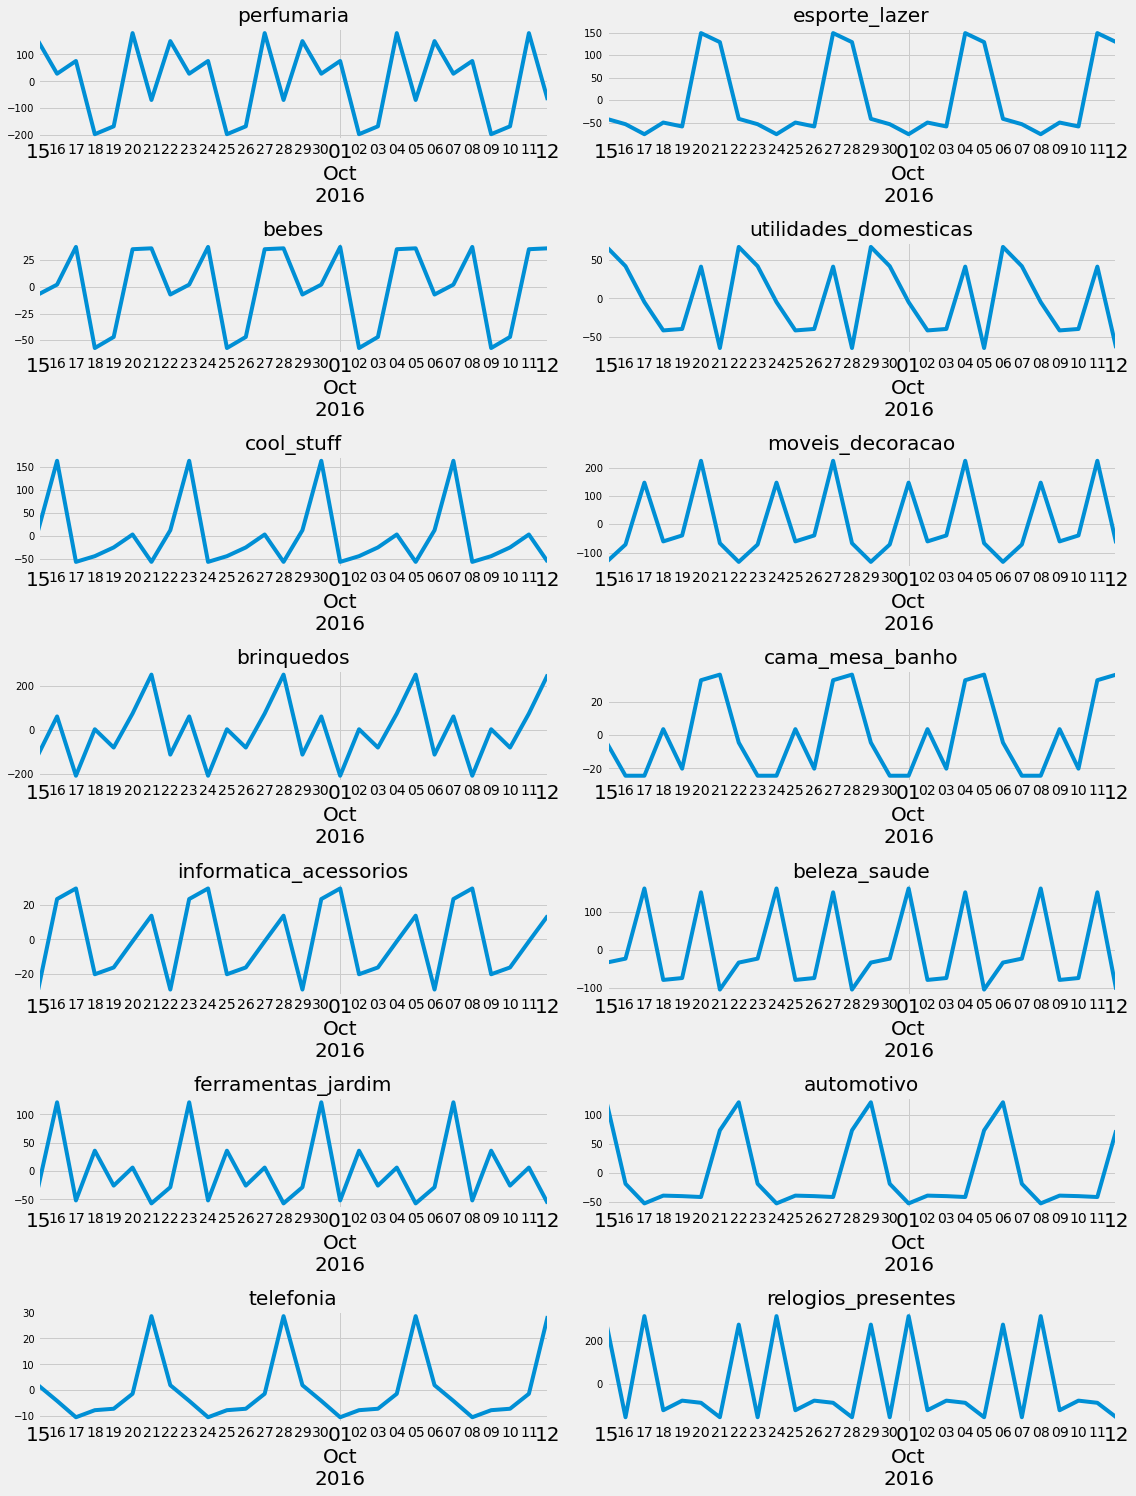

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('fivethirtyeight')

# Create a figure with 7 rows and 2 columns to accommodate 14 groups of our interest
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(16, 21))  
axes = axes.flatten()
for ax, (key, df) in zip(axes, categories_dict.items()):
    ts = df.value
    magified_seasonality = ts.iloc[0:28]
    magified_seasonality = magified_seasonality.asfreq('D')
    decomp = seasonal_decompose(magified_seasonality, model='additive')   
    # Plot the seasonal component
    decomp.seasonal.plot(ax=ax)
    ax.set_title(key)
    ax.tick_params(axis='x', labelsize=20)  
    ax.tick_params(axis='y', labelsize=10)  
# Hide any unused subplots
for i in range(len(categories_dict), len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

Okay, the above output makes it clear that the business operates on a weekly rhythm; therefore, our window_length parameter in make_reduction() should be set to 7.

In [26]:
# here is our search space
hypergrid = {
    'gbr': {
        "estimator__learning_rate":[0.01, 0.1, 0.5],
        "estimator__warm_start":[True, False]        
    },
    'RandForest': {
        "estimator__n_estimators":[30, 50, 100, 150],
        "estimator__warm_start":[True, False]
    }}

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# here are our regressors
regressors = {
    'gbr': GradientBoostingRegressor(),
    'RandForest': RandomForestRegressor(criterion='absolute_error'),
}

For every category, model space is researched using ForecastingGridSearchCV and ExpandingWindowSplitter and best model is refitted with whole data and saved. It will take a while, so be aware before running the below cell.

In [28]:
%%time
# data tabulation
from sktime.forecasting.compose import make_reduction
# forecst horizon
from sktime.forecasting.base import ForecastingHorizon
# hypertuning
from sktime.forecasting.model_selection import ForecastingGridSearchCV, ExpandingWindowSplitter
# metric
from sktime.performance_metrics.forecasting import MeanAbsoluteError

# container for refitted saved models; keys are categories, and values are best model for each group
models = {}

categories_summary['ML_RMSE'] = 0
categories_summary['ML_MAE'] = 0

for key in categories_dict.keys():
    print(f'*[sklearn/sktime] Starting training for {key} category...')
    start = time.time()
    
    # data preparation
    ts = categories_dict[key].value
    ts = pd.DataFrame(ts)
    
     # train/test split 
    y_train = ts.iloc[:len(ts)-21]
    y_test = ts.iloc[len(ts)-21:]
    y_train = y_train.asfreq('D')
    
    # training
    fit_models = {}
    for algo in regressors.keys():
        regressor = regressors[algo]
        # Since we have weekly seasonality, window_length for tabularization is 7
        forecaster = make_reduction(regressor, strategy="direct", window_length=7)  
        fh_cv=ForecastingHorizon(np.arange(1, 22))
        # cross-validation using ExpandingWindowSplitter will have 5 steps
        cv = ExpandingWindowSplitter(fh=fh_cv, initial_window=int(len(y_train)-105), step_length=21)  
        fgscv = ForecastingGridSearchCV(forecaster, 
                                        cv=cv, 
                                        param_grid=hypergrid[algo], 
                                        scoring=MeanAbsoluteError())
        fh=ForecastingHorizon(np.arange(1, 22))
        fgscv.fit(y_train, fh=fh)
        fit_models[algo]=fgscv
    
    # Forecasting and evaluating
    first_algo = True
    for algo in regressors.keys():
        if first_algo == True:
            y_pred = fit_models[algo].predict(fh)
            algo_MAE = np.mean(np.abs(y_test - y_pred)).value
            algo_RMSE = (np.mean((y_pred - y_test)**2)**.5).value
            best_MAE = algo_MAE
            best_RMSE = algo_RMSE
            best_algo = algo
            first_algo = False
            continue
        y_pred = fit_models[algo].predict(fh)
        algo_MAE = np.mean(np.abs(y_test - y_pred)).value
        algo_RMSE = (np.mean((y_pred - y_test)**2)**.5).value
        if algo_MAE < best_MAE:
            best_MAE = algo_MAE
            best_RMSE = algo_RMSE
            best_algo = algo
    categories_summary.loc[key, 'ML_RMSE'] = best_RMSE
    categories_summary.loc[key, 'ML_MAE'] = best_MAE
    
    # Refitting with all data (y_test included)
    y_train = ts
    y_train = y_train.asfreq('D')
    regressor = regressors[best_algo]
    forecaster = make_reduction(regressor, strategy="direct", window_length=7)
    fh_cv=ForecastingHorizon(np.arange(1, 22))
    cv = ExpandingWindowSplitter(fh=fh_cv, initial_window=int(len(y_train)-105), step_length=21)
    fgscv = ForecastingGridSearchCV(forecaster, 
                                    cv=cv, 
                                    param_grid=hypergrid[best_algo], 
                                    scoring=MeanAbsoluteError())
    fh=ForecastingHorizon(np.arange(1, 22))
    fgscv.fit(y_train, fh=fh)
    
    # Saving the best ML model into the dictionary for future use
    models[key] = fgscv
    
    end = time.time()
    elapsed_time_seconds = end - start
    elapsed_time_minutes = elapsed_time_seconds / 60
    print(f' [sklearn/sktime] Best model for {key} fitted. ({elapsed_time_minutes:.2f} min)')

*[sklearn/sktime] Starting training for perfumaria category...
 [sklearn/sktime] Best model for perfumaria fitted. (6.37 min)
*[sklearn/sktime] Starting training for esporte_lazer category...
 [sklearn/sktime] Best model for esporte_lazer fitted. (5.25 min)
*[sklearn/sktime] Starting training for bebes category...
 [sklearn/sktime] Best model for bebes fitted. (5.16 min)
*[sklearn/sktime] Starting training for utilidades_domesticas category...
 [sklearn/sktime] Best model for utilidades_domesticas fitted. (9.91 min)
*[sklearn/sktime] Starting training for cool_stuff category...
 [sklearn/sktime] Best model for cool_stuff fitted. (6.05 min)
*[sklearn/sktime] Starting training for moveis_decoracao category...
 [sklearn/sktime] Best model for moveis_decoracao fitted. (6.01 min)
*[sklearn/sktime] Starting training for brinquedos category...
 [sklearn/sktime] Best model for brinquedos fitted. (7.10 min)
*[sklearn/sktime] Starting training for cama_mesa_banho category...
 [sklearn/sktime] Be

## 4.3) Performance summary  

In [29]:
categories_summary[['value', 'total_items_sold', 'Prophet_RMSE', 'ML_RMSE', 'Prophet_MAE', 'ML_MAE','data_absence_share']]

,value,total_items_sold,Prophet_RMSE,ML_RMSE,Prophet_MAE,ML_MAE,data_absence_share
beleza_saude,1233131,9465,1898.302,1704.088855,1453.469,1341.956790,0.156863
relogios_presentes,1166176,5859,2222.352,1502.845491,1891.098,1266.706769,0.200280
cama_mesa_banho,1023434,10953,1202.088,1104.884425,933.069,888.132125,0.163866
esporte_lazer,954852,8431,1786.769,1866.117800,1107.589,1215.842972,0.155462
informatica_acessorios,888724,7644,802.835,1102.922537,651.255,949.229492,0.169468
moveis_decoracao,711927,8160,1002.672,777.429036,822.952,611.481209,0.154062
utilidades_domesticas,615628,6795,1457.605,1461.585426,1152.676,1140.650614,0.179272
cool_stuff,610204,3718,399.349,681.896954,335.308,620.360229,0.182073
automotivo,578966,4140,1385.637,1368.528960,1105.365,966.334854,0.189076
brinquedos,471286,4030,310.442,453.627785,248.267,375.931837,0.175070


# 5) Forecasting for product groups
Forecasting with best approach for a category.

In [30]:
categories_summary['Prophet_MAE'].mean(), categories_summary['ML_MAE'].mean(), categories_summary['Prophet_RMSE'].mean(), categories_summary['ML_RMSE'].mean()

(870.9418571428572, 809.8246317058794, 1093.7285, 1028.1993358888617)

In general, the ML solution produced better results across different product groups.

## 5.1) Forecasting with Prophet model
If we are intrested in forecasting for category 'brinquedos' it is the Prophet model that seems to be the best choice in terms of erros.

In [31]:
categories_summary.loc['brinquedos']

value                 471286.000000
total_items_sold        4030.000000
data_absence_count       125.000000
data_absence_share         0.175070
Prophet_RMSE             310.442000
Prophet_MAE              248.267000
ML_RMSE                  453.627785
ML_MAE                   375.931837
Name: brinquedos, dtype: float64

### Plotting forecasts vs actuals
But first, let's actually plot some forecasts against actuals in order to get a better sense of how the model is performing.

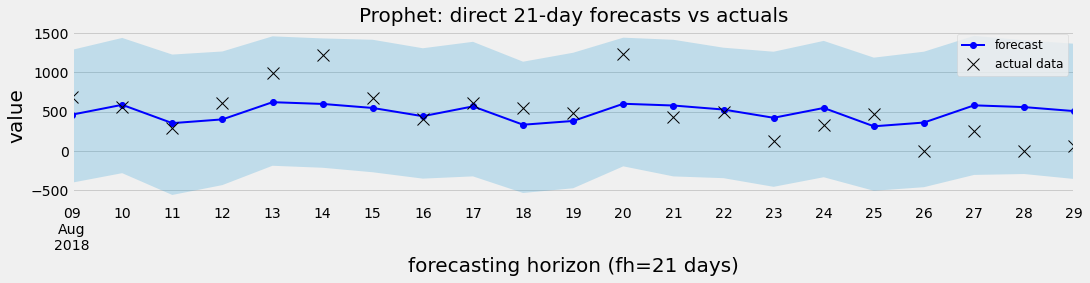

In [32]:
# generating forecasts for plotting
ts = categories_dict['brinquedos'].value 
ts = pd.DataFrame(ts)
ts.reset_index(inplace=True)
ts.columns = ['time','value']
kats_ts = TimeSeriesData(ts)
y_train = kats_ts[:len(kats_ts)-21]
y_test = ts[len(kats_ts)-21:]

params = ProphetParams()
m = ProphetModel(y_train, params)
m.fit()

fcst = m.predict(steps=21, freq="D")
fcst.set_index('time', inplace=True)
y_test.set_index('time', inplace=True)
evaluation_df = fcst.assign(y_test=y_test['value'])

# plotting
plt.figure()
evaluation_df['fcst'].plot(label='forecast', color='blue', marker='o', linewidth=2)
evaluation_df['y_test'].plot(label='actual data', color='black', marker='x', markersize=12, linestyle='None')
plt.fill_between(evaluation_df.index, evaluation_df['fcst_lower'], evaluation_df['fcst_upper'], alpha=0.2)
plt.title('Prophet: direct 21-day forecasts vs actuals', size=20)
plt.xlabel('forecasting horizon (fh=21 days)', size=20)
plt.ylabel('value', size = 20)
plt.gcf().set_size_inches(16, 3)
plt.legend(loc=1, prop={'size': 12})
plt.show()

Metrics associated with this forecast are actually the metrics found in categories_summary, where we evaluated performences for each category.

In [33]:
metrics = evaluation_metrics(evaluation_df['y_test'], evaluation_df['fcst'])
metrics

{'RMSE': 310.442, 'MAE': 248.267}

### Forecasting into the future with Prophet
We would need to refit again the model for whole dataset in order to produce the acual forecasts.

In [34]:
ts = categories_dict['brinquedos'].value 
ts = pd.DataFrame(ts)
ts.reset_index(inplace=True)
ts.columns = ['time','value']
y_train = TimeSeriesData(ts)

params = ProphetParams()
m = ProphetModel(y_train, params)
m.fit()

fcst = m.predict(steps=21, freq="D")

fcst.set_index('time', inplace=True)
fcst

,fcst,fcst_lower,fcst_upper
time,,,
2018-08-30,400.550717,-386.755577,1322.204824
2018-08-31,524.203262,-278.290584,1375.511141
2018-09-01,296.401422,-563.864671,1159.848089
2018-09-02,340.744341,-472.976264,1219.321016
2018-09-03,566.285868,-207.462836,1444.026983
2018-09-04,536.524458,-361.999994,1373.652564
2018-09-05,482.690133,-303.627727,1306.889741
2018-09-06,380.348458,-460.884078,1242.188796
2018-09-07,504.001004,-273.622297,1350.750907


## 5.2) Forecasting with ML model
Lets say our category of focus is 'bebes'.

In [35]:
categories_summary.loc['bebes']

value                 400421.000000
total_items_sold        2982.000000
data_absence_count       153.000000
data_absence_share         0.214286
Prophet_RMSE             809.011000
Prophet_MAE              754.537000
ML_RMSE                  550.496018
ML_MAE                   467.242339
Name: bebes, dtype: float64

Here are essential details about the actual best ML model found for this particular category:

In [36]:
models['bebes'].best_forecaster_

DirectTabularRegressionForecaster(estimator=GradientBoostingRegressor(learning_rate=0.01, warm_start=True),
                                  window_length=7)

### Forecasting into the future with ML model
Forecasting into the future with the ML model has been simplified as much as possible. The best ML model for each category is stored in a dedicated dictionary (models). Models are refitted with the entire dataset after evaluation and will produce forecasts for the next 21 days (the forecasting horizon has already been specified during training).

In [37]:
models['bebes'].predict(fh)

,value
2018-08-30,288.228398
2018-08-31,356.191860
2018-09-01,342.952442
2018-09-02,444.954453
2018-09-03,376.695850
2018-09-04,315.948126
2018-09-05,493.375835
2018-09-06,353.773969
2018-09-07,434.814217
2018-09-08,364.475858
